In [1]:
! pwd

/home/bsherwin51/Renaissance/Void


In [2]:
import h5py as h
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
import sys, os, time
import optuna

In [3]:
ds = h.File('catalog.h5')

In [4]:
# N hidden layer code, similar structure to above but generalized
def dynamic_model2(input_size, output_size, n_layers, hidden, dr):

    # define the tuple containing the different layers
    layers = []

    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = hidden[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dr[i]))
        in_features = out_features

    # get the last layer
    layers.append(nn.Linear(out_features, output_size))

    # return the model
    return nn.Sequential(*layers)

#model = dynamic_model2(numFeatures, outSize, numHL, [h1, h2], [dr1, dr1])

In [5]:
from random import shuffle
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import sys, os, time, h5py
from pathlib import Path

In [6]:
def normalize_data(data, labels):
    ######################
    # normalize input
    ## the id's correspond to the id's of the feature array you made using vstack in read_data()
    data[:,0]  = (data[:,0] - np.mean(data[:,0]))/np.std(data[:,0]) # Z Scores
    data[:,1]  = (data[:,1] - np.mean(data[:,1]))/np.std(data[:,1])
    data[:,2]  = (data[:,2] - np.mean(data[:,2]))/np.std(data[:,2])
    data[:,3]  = (data[:,3] - np.mean(data[:,3]))/np.std(data[:,3])
    data[:,4]  = (data[:,4] - np.mean(data[:,4]))/np.std(data[:,4])

    ######################
    # normalize labels
    print ("labels", labels)

    # # array = np.log10(labels) # Since labels are large log them
    # print("labels array", array)
    # labels = array
    
    return data, labels

In [7]:
# read data and get training, validation or testing sets
# fin ---------> file with the data
# seed --------> random seed used to split among different datasets
# mode --------> 'train', 'valid', 'test' or 'all'
# normalize ---> whether to normalize the data or not
def read_data(fin, seed, mode, normalize): #fin for h5
    File = 'catalog.h5'
    f     = h5py.File(fin, 'r')
    masses = []
    fgases = []
    SFRs = []
    Mstars = []
    redshifts = []
    fescs = []
    groups = []
    min_dist = []
    t_lookback = []
    
    t_lookback_RP = np.array(np.load('t_lookback_void.npy', allow_pickle = True))
    t_lookback_all = []
    for list_i in t_lookback_RP:
        for elem in list_i:
            t_lookback_all.append(elem)
        
    min_dist_RP = np.array(np.load('min_dist_void.npy', allow_pickle = True))
    min_dist_all = []
    for listi in min_dist_RP:
        for elem in listi:
            min_dist_all.append(elem)
    
    for halo in f.keys():
        fesc_list = list(f[halo]['fesc']) 
        for index, fesc in enumerate(fesc_list):
            if fesc <= 0.01:
                group = 0
            elif 0.01 < fesc <= 0.10:
                group = 1
            elif 0.10 < fesc <= 0.25:
                group = 2
            else:
                group = 3
                
            if fesc >= 1e-5:
                masses.append(f[halo]['mass'][index])
                fgases.append(f[halo]['fgas'][index])
                SFRs.append(f[halo]['SFR'][index])
                Mstars.append(f[halo]['Mstar'][index])
                redshifts.append(f[halo]['redshift'][index])
                fescs.append(fesc)
                groups.append(group)
                t_lookback.append(t_lookback_all[index])
                min_dist.append(min_dist_all[index])
    # min_SFR = np.min(SFRs[SFRs != 0])
    minsfr = 100
    for each in SFRs:
        if each < minsfr and each != 0.:
            minsfr = each
    new_SFRs = []
    for SFR in SFRs:
        if SFR == 0.0:
            new_SFRs.append(minsfr*0.9)
        else:
            new_SFRs.append(SFR)        
    # normalize data - EDIT
    ## anything not on order 10^0 - 10^1 should be logged
    masses = np.log10(masses)
    SFRs = np.log10(new_SFRs)
    Mstars = np.log10(Mstars)
    fgases = np.log10(fgases)
    min_dist = np.log10(min_dist)
    t_lookback = np.log10(t_lookback)
    
    # get data, labels and number of elements
    data = np.vstack([SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback]).T # THESE ARE YOUR CHOSEN INPUT VARIABLES
    
    labels = np.array(groups, dtype = 'int')
    print("labels.shape", labels.shape)
    # labels = fluxes.reshape((fluxes.shape[0], fluxSize))
    elements = data.shape[0]
    
    # normalize data
    if normalize:  data, labels = normalize_data(data, labels)

    # get the size and offset depending on the type of dataset
    if   mode=='train':   size, offset = int(elements*0.70), int(elements*0.00)
    elif mode=='valid':   size, offset = int(elements*0.15), int(elements*0.70)
    elif mode=='test':    size, offset = int(elements*0.15), int(elements*0.85)
    elif mode=='all':     size, offset = int(elements*1.00), int(elements*0.00)
    else:                 raise Exception('Wrong name!')

    # randomly shuffle the cubes. Instead of 0 1 2 3...999 have a 
    # random permutation. E.g. 5 9 0 29...342
    np.random.seed(seed)
    indexes = np.arange(elements) 
    np.random.shuffle(indexes)
    indexes = indexes[offset:offset+size] #select indexes of mode

    return data[indexes], labels[indexes]



In [8]:
class make_dataset():

    def __init__(self, mode, seed, fin):

        # get data
        inp, out = read_data(fin, seed, mode, normalize=True)

        # get the corresponding bottlenecks and parameters
        self.size   = inp.shape[0]
        self.input  = torch.tensor(inp, dtype=torch.float32)
        self.output = torch.tensor(out, dtype= torch.long)
        
        print ("size of input and output", np.shape(self.input), np.shape(self.output))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [9]:
def create_dataset(mode, seed, fin, batch_size, shuffle):
    data_set = make_dataset(mode, seed, fin)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return dataset_loader

In [25]:
fin = 'catalog.h5'
dataname = 'Void'      # Nickname for data
seed = 20                # remember this to reproduce split
numFeatures = 7         # number of input properties
outSize = 4          # size of wavelength array
featurelist = 'SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback'

# OPTUNA HYPERPARMETERS
numHL = 1          # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_1 = 300 #197           # nodes in second hidden layer
h2_1 = 500
h3_1 = 319
dr1_1 = 0.37957525032509143
dr2_1 = 0.45950651430594097
dr3_1 = 0.2042671535105191
lr_1 = 0.0009094501011908492
wd_1 = 0.0001609574990955836

In [26]:
batch_size = 50
epochs = 75

In [27]:
# name of output files


name   = "Normal_dynamicmodel2"
device = torch.device('cpu')
# define loss function
criterion = nn.CrossEntropyLoss()  # MSE or Cross Entropy

# get train, validation, and test sets
print('preparing dataset...')
train_loader = create_dataset('train', seed, fin, batch_size, True)
valid_loader = create_dataset('valid', seed, fin, batch_size, False)
test_loader  = create_dataset('test',  seed, fin, batch_size, False)



preparing dataset...
labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1

In [29]:
model = dynamic_model2(numFeatures, outSize, numHL, [h1_1], [dr1_1])

In [30]:
fout   = 'voidtest5.txt'
fmodel = 'voidtest5.pt'
#casts parameters/buffers to specified gpu
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_1, betas=(0.5, 0.999), 
                              weight_decay=wd_1)

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):
    correct = 0
    total_ct = 0
    # do training
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model(x)
        #y = nn.Softmax(y)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
            
            m = nn.Softmax(dim = 1)
            y_NN = m(y_NN)
            for idx, value in enumerate(y_NN):
                if value.tolist().index(max(value)) == y[idx]:
                    correct += 1
                total_ct += 1
    accuracy = correct/total_ct
    test_loss /= points
    
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = test_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print(f'Accuracy:{accuracy}')
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 3604
000 1.812e+00 1.335e+00 (saving)
001 1.648e+00 1.171e+00 (saving)
002 1.533e+00 1.381e+00
003 1.470e+00 1.105e+00 (saving)
004 1.392e+00 1.228e+00
005 1.310e+00 1.130e+00
006 1.297e+00 1.077e+00 (saving)
007 1.292e+00 1.075e+00 (saving)
008 1.280e+00 1.199e+00
009 1.196e+00 1.057e+00 (saving)
010 1.266e+00 1.065e+00
011 1.227e+00 1.085e+00
012 1.214e+00 1.282e+00
013 1.170e+00 1.129e+00
014 1.207e+00 1.063e+00
015 1.150e+00 1.065e+00
016 1.157e+00 1.072e+00
017 1.165e+00 1.035e+00 (saving)
018 1.161e+00 1.049e+00
019 1.173e+00 1.051e+00
020 1.115e+00 1.159e+00
021 1.116e+00 1.053e+00
022 1.082e+00 1.085e+00
023 1.047e+00 1.067e+00
024 1.078e+00 1.123e+00
025 1.076e+00 1.165e+00
026 1.116e+00 1.063e+00
027 1.082e+00 1.143e+00
028 1.063e+00 1.089e+00
029 1.037e+00 1.104e+00
030 1.030e+00 1.188e+00
031 1.072e+00 1.092e+00
032 1.036e+00 1.037e+00
033 1.055e+00 1.023e+00 (saving)
034 1.031e+00 1.101e+00
035 1.028e+00 1.054e+00
036 1.023e+00 1.0

In [31]:
fout   = 'voidvalid5.txt'
fmodel = 'voidtest5.pt'
#casts parameters/buffers to specified gpu
model.load_state_dict(torch.load(fmodel))
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr_1,
                             weight_decay=wd_1)	

start = time.time()
min_valid_loss = 1000
valid_loss, points = 0.0, 0
valid_losses = []
for epoch in range(epochs):
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            valid_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    valid_loss /= points

    # save model if it is better
    if valid_loss<min_valid_loss:
    #     torch.save(model.state_dict(), fmodel)
         min_valid_loss = valid_loss
         print('%03d %.3e (saving)'%(epoch, valid_loss))
    else:
         print('%03d %.3e'%(epoch, valid_loss))

    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e \n'%(epoch, valid_loss))
    f.close()
    valid_losses.append(valid_loss)
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 3604
000 1.014e+00 (saving)
001 5.114e-01 (saving)
002 3.395e-01 (saving)
003 2.543e-01 (saving)
004 2.033e-01 (saving)
005 1.693e-01 (saving)
006 1.451e-01 (saving)
007 1.269e-01 (saving)
008 1.128e-01 (saving)
009 1.015e-01 (saving)
010 9.228e-02 (saving)
011 8.459e-02 (saving)
012 7.808e-02 (saving)
013 7.250e-02 (saving)
014 6.766e-02 (saving)
015 6.343e-02 (saving)
016 5.970e-02 (saving)
017 5.638e-02 (saving)
018 5.341e-02 (saving)
019 5.074e-02 (saving)
020 4.832e-02 (saving)
021 4.612e-02 (saving)
022 4.412e-02 (saving)
023 4.228e-02 (saving)
024 4.059e-02 (saving)
025 3.902e-02 (saving)
026 3.758e-02 (saving)
027 3.624e-02 (saving)
028 3.499e-02 (saving)
029 3.382e-02 (saving)
030 3.273e-02 (saving)
031 3.171e-02 (saving)
032 3.074e-02 (saving)
033 2.984e-02 (saving)
034 2.899e-02 (saving)
035 2.818e-02 (saving)
036 2.742e-02 (saving)
037 2.670e-02 (saving)
038 2.601e-02 (saving)
039 2.536e-02 (saving)
040 2.474e-02 (saving)
041 2.415e

In [42]:
losses = np.loadtxt('voidtest5.txt', delimiter = ' ')
train_losses = losses[:,1]
test_losses = losses[:,2]

(-5.0, 75.0)

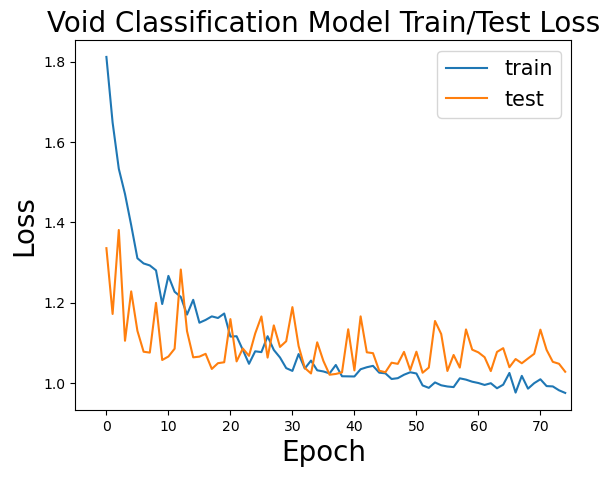

In [47]:
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend(fontsize = 15)
plt.title("Void Classification Model Train/Test Loss", fontsize = 20)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.savefig("Void Train_Test.png")
plt.xlim(-5, 75)

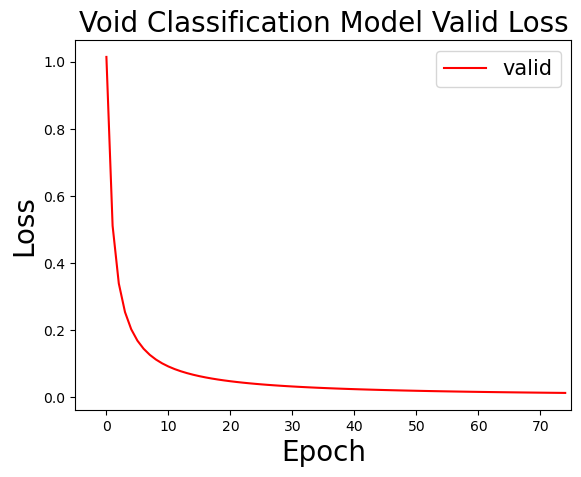

In [46]:
plt.plot(valid_losses, color = 'r', label = 'valid')
plt.legend(fontsize = 15)
plt.title("Void Classification Model Valid Loss", fontsize = 20)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.xlim(-5,75)
plt.savefig("Void Valid.png")